# Autoregressive logistic regression

In [1]:
import pandas as pd

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import scipy.special as ss

3.5


In [2]:
SEED = 20180727

In [3]:
obs = [int(i) for i in '111111110001111100000001111000100000111111110011000000011111100000000011111110000000']
obs = np.asarray(obs)
print(obs)
print(obs.shape)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 0]
(84,)


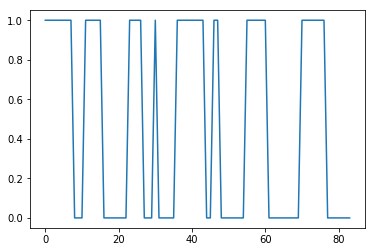

In [4]:
plt.plot(obs);

To build an autoregressive model, I use the observation at `t-1` as predictor for the observation at `t`

In [5]:
obs_t = obs[1:]
obs_t_minus_1 = obs[0:-1]

assert(obs_t.shape == obs_t_minus_1.shape)

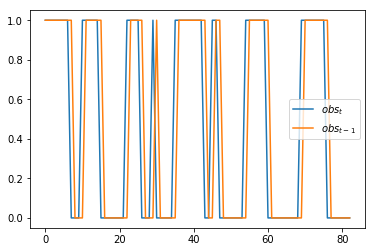

In [6]:
plt.plot(obs_t, label='$obs_t$')
plt.plot(obs_t_minus_1, label='$obs_{t-1}$')
plt.legend()
pass

In [7]:
df = pd.DataFrame({'t':np.arange(obs[2:].shape[0]),
                   'obs_t':obs[2:],
                   'obs_t_minus_1':obs[1:-1],
                   'obs_t_minus_2':obs[0:-2]})
df.head()

,t,obs_t,obs_t_minus_1,obs_t_minus_2
0,0,1,1,1
1,1,1,1,1
2,2,1,1,1
3,3,1,1,1
4,4,1,1,1


In [8]:
Y, X = patsy.dmatrices('obs_t ~ obs_t_minus_1', data=df)
Y.flatten(), X

(array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]),
 DesignMatrix with shape (82, 2)
   Intercept  obs_t_minus_1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              0
           1              0
           1              0
           1              1
           1              1
           1              1
           1              1
           1              1
           1              0
           1              0
           1              0
           1              0
           1              0
         

In [9]:
with pm.Model() as model:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=np.asarray(X).shape[1])
    
    p = pm.math.invlogit(pm.math.dot(np.asarray(X), beta))
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=Y.flatten())
    
    trace = pm.sample(draws=1000, tune=500, chains=2, cores=1, random_seed=SEED, nuts_kwargs={'target_accept':0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1037.94it/s]
C:\Miniconda3\envs\bayes\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


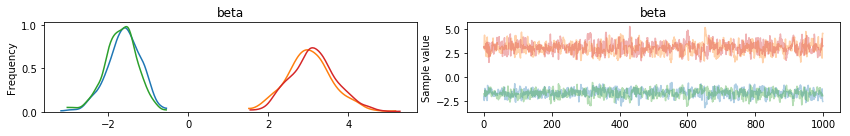

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace)

C:\Miniconda3\envs\bayes\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-1.654871,0.413195,0.016601,-2.503462,-0.901388,542.643628,1.008803
beta__1,3.076788,0.576302,0.022952,1.986916,4.254355,542.235808,1.008045


In the Agresti's book the results are $(\alpha, \beta) = (-1.609, 2.996)$

In [12]:
with model:
    ppc = pm.sample_ppc(trace)
    
ppc['likelihood'].shape

C:\Miniconda3\envs\bayes\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 763.51it/s]


(1000, 82)

In [13]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,beta__0,beta__1
0,-1.975278,2.995232
1,-2.425089,3.510146
2,-2.197337,4.389137
3,-1.164774,2.836647
4,-1.997332,3.749477


In [14]:
trace_df.mean(axis=0)

beta__0   -1.654871
beta__1    3.076788
dtype: float64

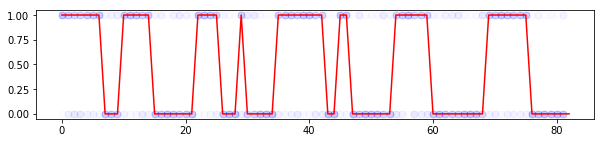

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

plt.plot(ppc['likelihood'][::50].T, color='blue', alpha=0.01, ls='none', marker='o', markersize=7, label='$PPC$')
    
plt.plot(obs_t, color='red', label='$obs_t$')
pass

# The graph hints that the model is capturing the effect. However, beacuse of the sampling of the binomial distribution I have a lot of noise. The samples, in fact, can either be 0 or 1 and not something close t

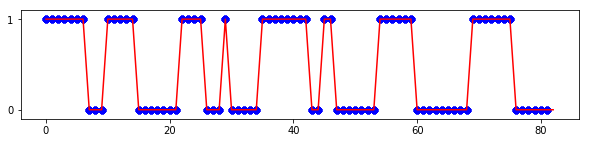

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

for beta in zip(trace_df['beta__0'][::10], trace_df['beta__1'][::10]):
    p = ss.expit(np.dot(np.asarray(X), np.asarray(beta)))
    # By thresholding P, I remove the sampling error. In fact, a p=0.8 does not necessarly output a 1 in the binomial random sampling.
    # with the threshold p>=0.5 I obtain an array of zeros and ones
    plt.plot(p>=0.5, alpha=0.008, ls='none', marker='o', markersize=7, color='blue', lw=1)
    
plt.plot(obs_t, color='red', label='$obs_t$')
plt.ylim((-0.1, 1.1))
plt.yticks((0, 1))
pass

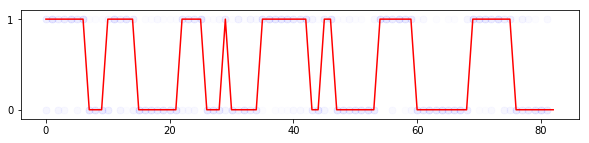

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

for beta in zip(trace_df['beta__0'][::250], trace_df['beta__1'][::250]):
    p = ss.expit(np.dot(np.asarray(X), np.asarray(beta)))
    # By thresholding P, I remove the sampling error. In fact, a p=0.8 does not necessarly output a 1 in the binomial random sampling.
    # with the threshold p>=0.5 I obtain an array of zeros and ones
    samples = np.random.binomial(n=1, p=p) # here I use the binomial function, but I could have just thresholded the p directly
    plt.plot(samples, alpha=0.01, ls='none', marker='o', markersize=7, color='blue', lw=1)
    
plt.plot(obs_t, color='red', label='$obs_t$')
plt.ylim((-0.1, 1.1))
plt.yticks((0, 1))
pass

# Try BSTS implementation

In [9]:
Y, X = patsy.dmatrices('obs_t ~ 0 + obs_t_minus_1', data=df)
Y.flatten(), X

(array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]),
 DesignMatrix with shape (82, 1)
   obs_t_minus_1
               1
               1
               1
               1
               1
               1
               1
               0
               0
               0
               1
               1
               1
               1
               1
               0
               0
               0
               0
               0
               0
               0
               1
               1
               1
               1
               0
               0
               0
               1
   [52 rows omitted]
   Terms:
     'obs_t_minus_1' (column 0)
   (to 

In [10]:
with pm.Model() as model:

    sigma_alpha = pm.HalfNormal('sigma_alpha', sd=1)
    sigma_alpha_ = pm.HalfNormal('sigma_alpha_', sd=1)
    
    alpha_ = pm.GaussianRandomWalk('alpha_', sd=sigma_alpha_, shape=Y.flatten().shape[0])
    alpha = pm.AR1('alpha', k=1.0, tau_e=1/sigma_alpha**2, shape=Y.flatten().shape[0])

    beta = pm.Normal('beta', mu=0, sd=100, shape=np.asarray(X).shape[1])
    beta_ = pm.Normal('beta_', mu=0, sd=100, shape=np.asarray(X).shape[1])
    
    mu = alpha + tt.dot(np.asarray(X), beta)
    mu_ = alpha_ + tt.dot(np.asarray(X), beta_)
    
    p = pm.math.invlogit(mu)
    p_ = pm.math.invlogit(mu_)
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=Y.flatten())
    likelihood_ = pm.Bernoulli('likelihood_', p=p_, observed=Y.flatten())
    
    trace = pm.sample(draws=1000, tune=500, chains=2, cores=1, random_seed=SEED, nuts_kwargs={'target_accept':0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_, beta, alpha, alpha_, sigma_alpha_, sigma_alpha]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:41<00:00, 14.75it/s]
C:\Miniconda3\envs\bayes\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6962024988001256, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase 

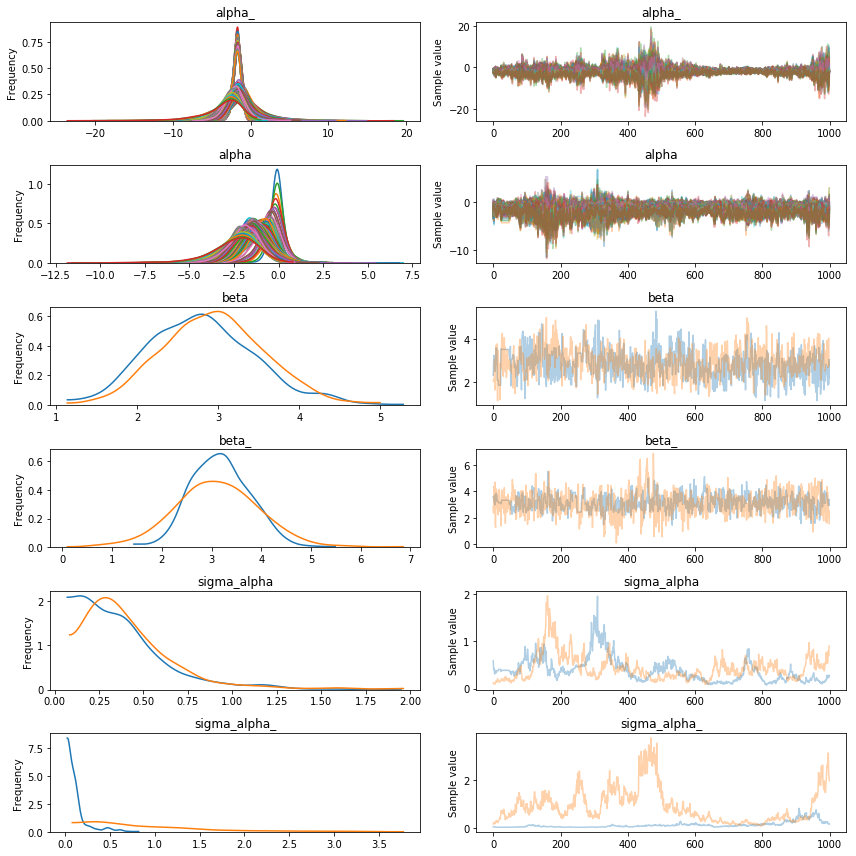

In [11]:
pm.traceplot(trace);

In [12]:
pm.summary(trace)

C:\Miniconda3\envs\bayes\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha___0,-0.636814,2.230821,0.150863,-3.497918,3.926959,6.071869,1.168296
alpha___1,-0.687202,2.067756,0.142903,-3.430561,3.486463,5.697886,1.181575
alpha___2,-0.795781,1.836408,0.127921,-3.325470,3.236102,6.205204,1.174090
alpha___3,-0.919457,1.630577,0.106582,-3.477771,2.438306,6.441119,1.159450
alpha___4,-1.073020,1.376675,0.082803,-3.406749,1.821105,8.060692,1.134795
alpha___5,-1.338397,1.141694,0.044811,-3.469675,1.165618,47.184230,1.047406
alpha___6,-1.688589,1.068971,0.049005,-3.671541,0.625010,186.344315,1.004577
alpha___7,-1.627914,1.030101,0.041019,-3.812592,0.481147,343.336893,0.999641
alpha___8,-1.471613,0.940177,0.032878,-3.227197,0.612694,206.359136,1.024656
alpha___9,-1.164863,1.124677,0.069162,-3.003642,1.470962,5.617854,1.168650


In [78]:
with model:
    ppc = pm.sample_ppc(trace)
    
ppc['likelihood'].shape

C:\Miniconda3\envs\bayes\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1578.19it/s]


(1000, 82)

In [13]:
trace['alpha'].shape, trace['alpha_'].shape

((2000, 82), (2000, 82))

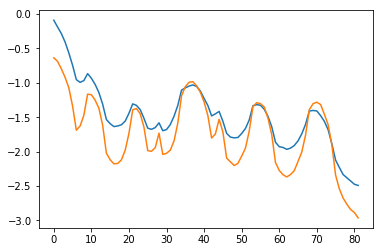

In [14]:
plt.plot(trace['alpha'].mean(axis=0));
plt.plot(trace['alpha_'].mean(axis=0));

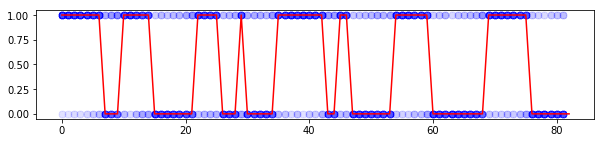

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

plt.plot(ppc['likelihood'][::10].T, color='blue', alpha=0.01, ls='none', marker='o', markersize=7, label='$PPC$')
    
plt.plot(obs_t, color='red', label='$obs_t$')
pass

# The graph hints that the model is capturing the effect. However, beacuse of the sampling of the binomial distribution I have a lot of noise. The samples, in fact, can either be 0 or 1 and not something close t